## Assignment 5.3

In [1]:
# Loading the Boston housing dataset

from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
# Normalizing the data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [3]:
#  Model definition
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [4]:
# K-fold validation

import numpy as np
k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    #Evaluates the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [5]:
all_scores

[1.8948631286621094, 2.5044777393341064, 2.8061509132385254, 2.805447816848755]

In [6]:
np.mean(all_scores)

2.502734899520874

In [7]:
from keras import backend as K
# Some memory clean-up
K.clear_session()

In [8]:
# Saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0) 
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
#  Building the history of successive mean K-fold validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

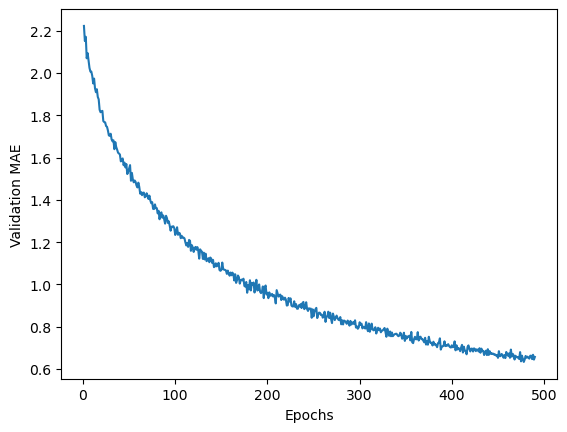

In [10]:
# Plotting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history[10:]) + 1), average_mae_history[10:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

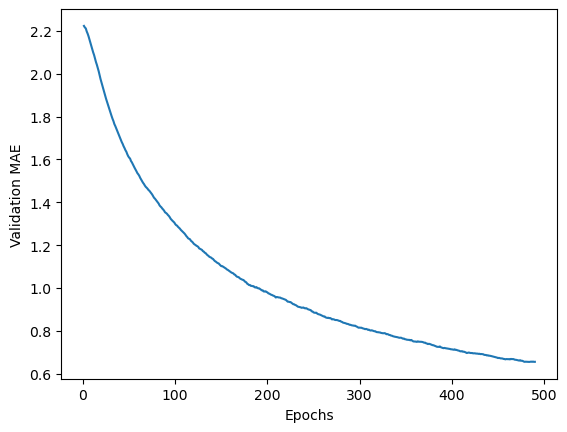

In [11]:
# Plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [12]:
# Training the final model

model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 5ms/step - loss: 19.2547 - mae: 2.9542


In [13]:
test_mae_score

2.9541919231414795

In [14]:
#Generating predictions on new data
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 3ms/step


array([9.292792], dtype=float32)